In [ ]:
import pymc as pm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pandas as pd
import pytensor.tensor as pt
import json

#Make sure it can see the system path

import sys
from pathlib import Path

PROJECT_ROOT = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))

from utils import load_data,plot_helpers
from modeling import bayes,viz


In [106]:
for_paper=True
for_talk=False

if for_paper:

    import scienceplots #http://doi.org/10.5281/zenodo.4106649
    plt.style.use(('science','nature'))
elif for_talk:
    plt.style.use("dark-background")
else:
    az.style.use("arviz-doc")
    
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load the data and lookup_table
Both from Norman - get reference?

In [3]:
lookup_table=xr.open_dataarray("data/carbon_cycle/lookup_table.nc")

carbon_cycle_cmip=load_data.load_carbon_cycle()

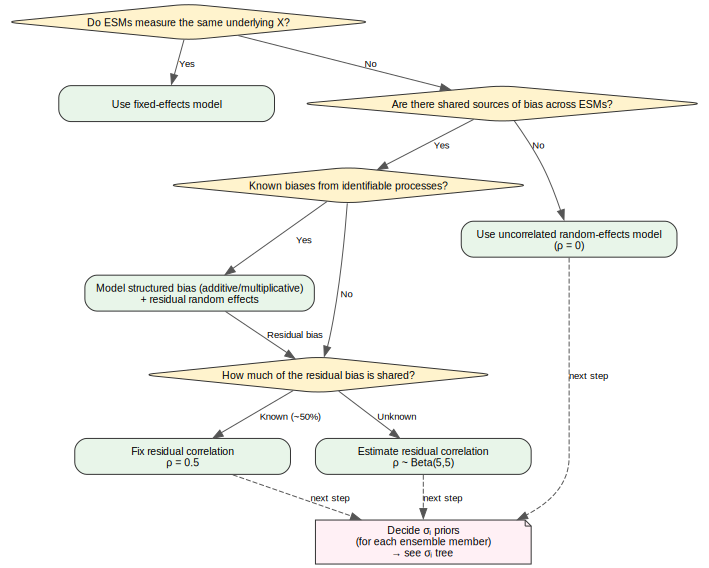

In [113]:
viz.show_highlevel_tree("paper",save_filename="FIGS/Highleveltree.pdf")

### Which processes are we considering?

In [52]:
lookup_table.process.values

array(['nitrogen', 'permafrost', 'fire', 'veg'], dtype=object)

# Explicitly modeling process inclusion/exclusion


## Nitrogen
Some models have nitrogen limitations, others don't.  The ones that do have lower $\beta_L$.  This is expected from physics: you can't take advantage of increased atmospheric CO2 if you're limited by something else.

In [101]:
def plot_comparison(proc_name):
    lookup_proc=lookup_table.sel(process=proc_name).values
    #az.plot_posterior(trace.posterior.betaL)
    #az.plot_posterior(processtrace05.posterior.betaL,ax=plt.gca(),c="r")
    sns.kdeplot(carbon_cycle_cmip["betaL"][np.where(lookup_proc)],color=cm.tab10(2),\
                fill=True,label=proc_name)
    sns.kdeplot(carbon_cycle_cmip["betaL"][np.where(lookup_proc==0)],color=cm.tab10(1),\
                fill=True,label=f"No {proc_name}")
    plt.legend()
    plt.xlabel(r"$\beta_{L}$")
    

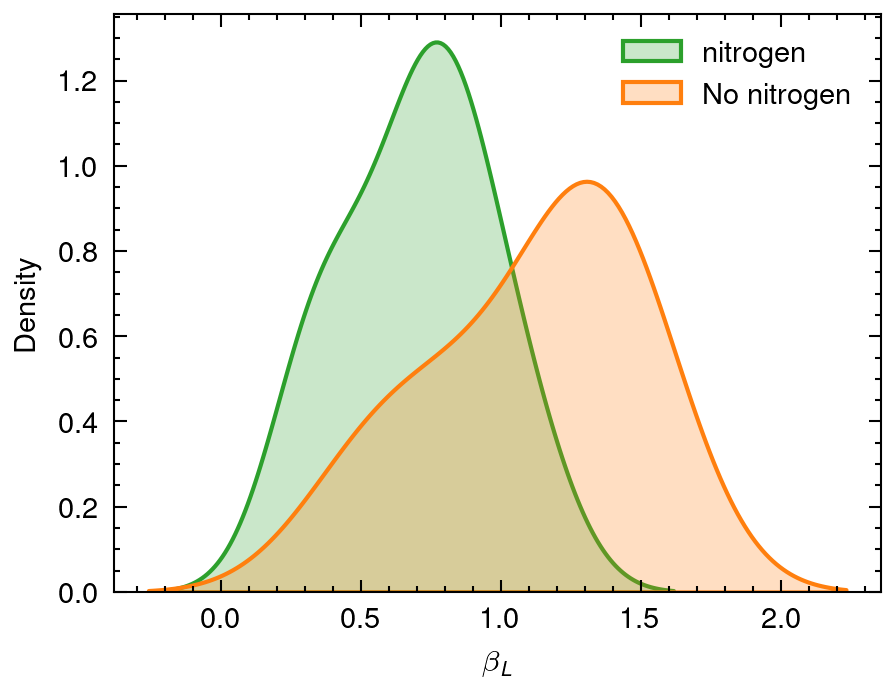

In [102]:
plot_comparison("nitrogen")

So let's model this explicitly:
$$ \beta_L^m \sim MN(\eta_N^{L_m}B_L,\Sigma)$$
where $L_m=1$ if ESM m has the process and $L_m=0$  otherwise.  $B_L$ is the unscaled CO2 effect in the absence of nitrogen limitations.

In [18]:
#
with bayes.build_correlated_bias_model_with_processes(
    carbon_cycle_cmip["betaL"],
    lookup_table,
    additive_processes=None,
    multiplicative_processes=["nitrogen"],
    priors={"sigma_iv": lambda name: .01, "betaL":lambda name: pm.LogNormal(name,0.0,0.5)},
    var_name="betaL",
    mu_iv=None,
) as nitrogenmodel:
    nitrogentrace=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaL_unscaled, sigma_struct, eta, rho, betaL_CMIP_unscaled]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


This leads to a posterior much closer to the "with nitrogen" models:

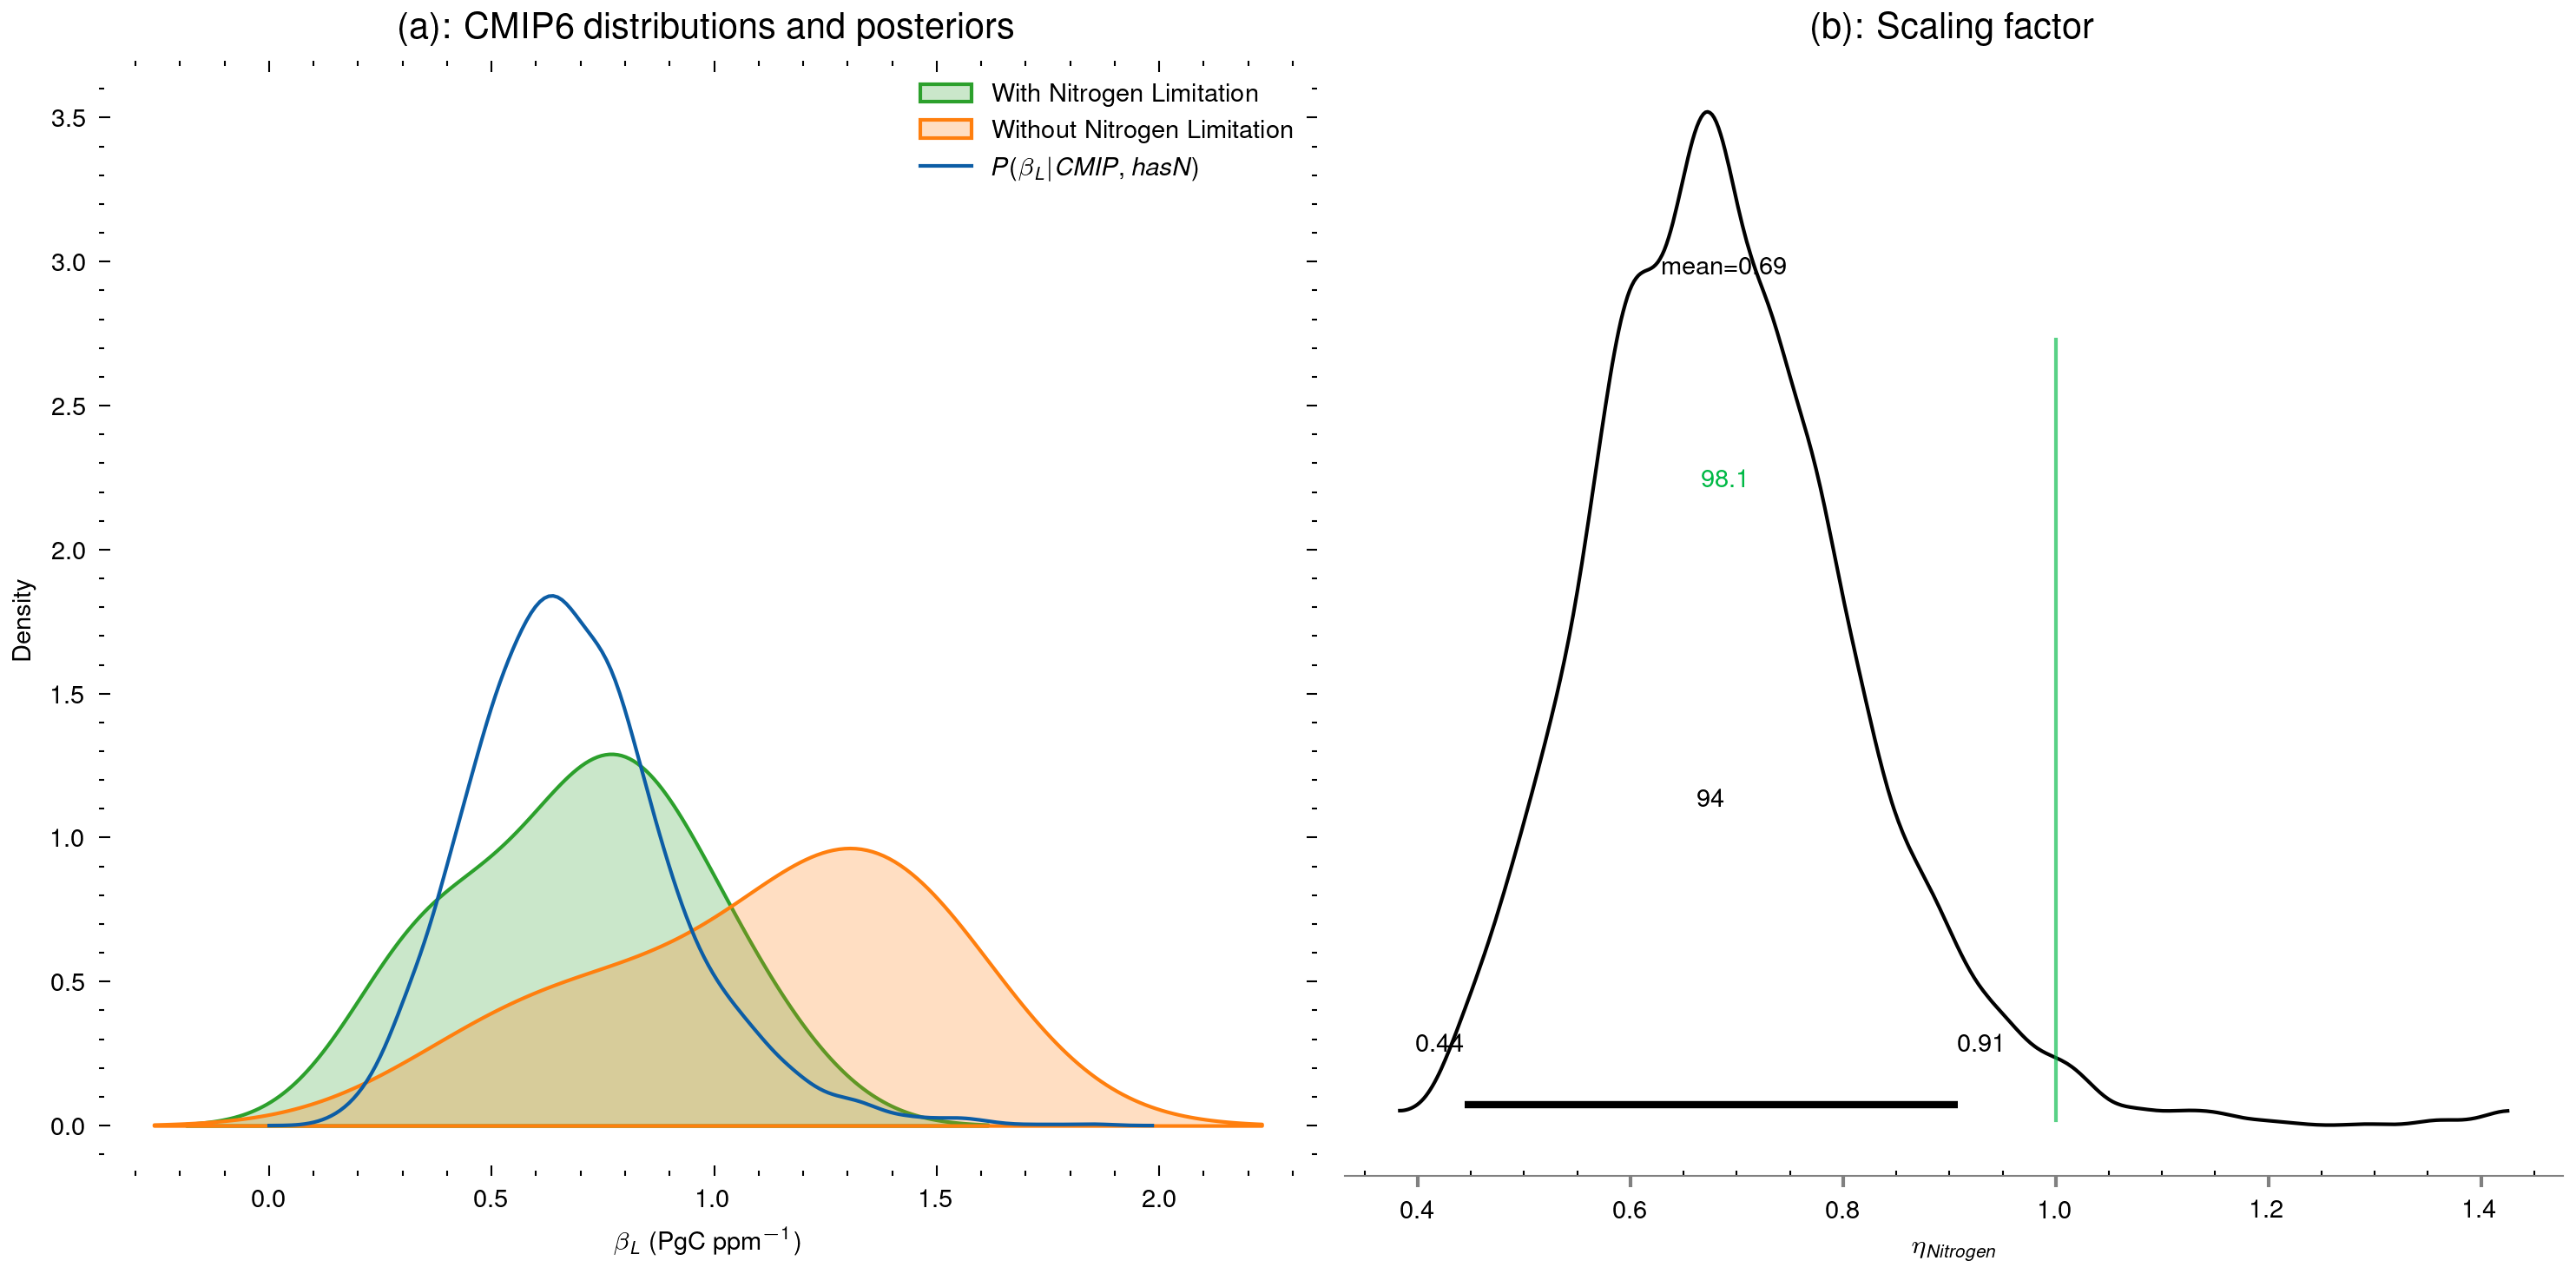

In [105]:
fig=plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
lookup_nitrogen=lookup_table.sel(process="nitrogen").values


sns.kdeplot(carbon_cycle_cmip["betaL"][np.where(lookup_nitrogen)],\
            color=cm.tab10(2),fill=True,label="With Nitrogen Limitation")
sns.kdeplot(carbon_cycle_cmip["betaL"][np.where(lookup_nitrogen==0)],\
            color=cm.tab10(1),fill=True,label="Without Nitrogen Limitation")


plot_helpers.plot_posterior(nitrogentrace,"betaL",label=r"$P(\beta_{L} | CMIP,hasN)$",ax=ax1)
ax1.set_frame_on(False)
plt.xlabel(r"$\beta_{L}$ (PgC ppm$^{-1})$")
plt.legend()
ax2=plt.subplot(122)
az.plot_posterior(nitrogentrace.posterior.eta,ref_val=1.0,ax=ax2,c="k")
ax2.set_xlabel(r"$\eta_{Nitrogen}$")
ax2.set_title("(b): Scaling factor")
ax1.set_ylim(ax2.get_ylim())
ax1.set_title("(a): CMIP6 distributions and posteriors")
plt.tight_layout()
plt.savefig("FIGS/Nitrogen.pdf")

This is because the model predicts a nonunit scaling factor eta (which it learns from the difference between the two groups).

<Axes: title={'center': 'eta\nnitrogen'}>

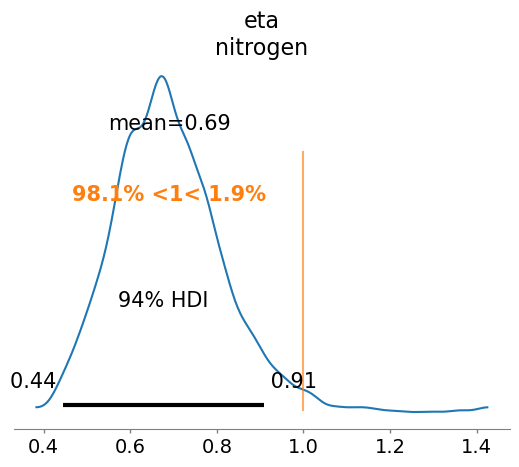

In [32]:
az.plot_posterior(nitrogentrace.posterior.eta,ref_val=1.0)

Now, build a correlated bias model with ALL processes, assuming
$$ \beta_L^m \sim MN(\prod_p\eta_p^{L_m}B_L+\delta_{permafrost},\Sigma)$$

In [33]:
#test
with bayes.build_correlated_bias_model_with_processes(
    carbon_cycle_cmip["betaL"],
    lookup_table,
    additive_processes=["permafrost"],
    multiplicative_processes=["nitrogen","fire","veg"],
    priors={"sigma_iv": lambda name: .01,  "betaL":lambda name: pm.LogNormal(name,0.0,0.5)},
    var_name="betaL",
    mu_iv=None,
) as allmodel:
    alltrace=pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betaL_unscaled, sigma_struct, eta, delta, rho, betaL_CMIP_unscaled]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 440 seconds.


array([<Axes: title={'center': 'eta\nnitrogen'}>,
       <Axes: title={'center': 'eta\nfire'}>,
       <Axes: title={'center': 'eta\nveg'}>,
       <Axes: title={'center': 'delta\npermafrost'}>], dtype=object)

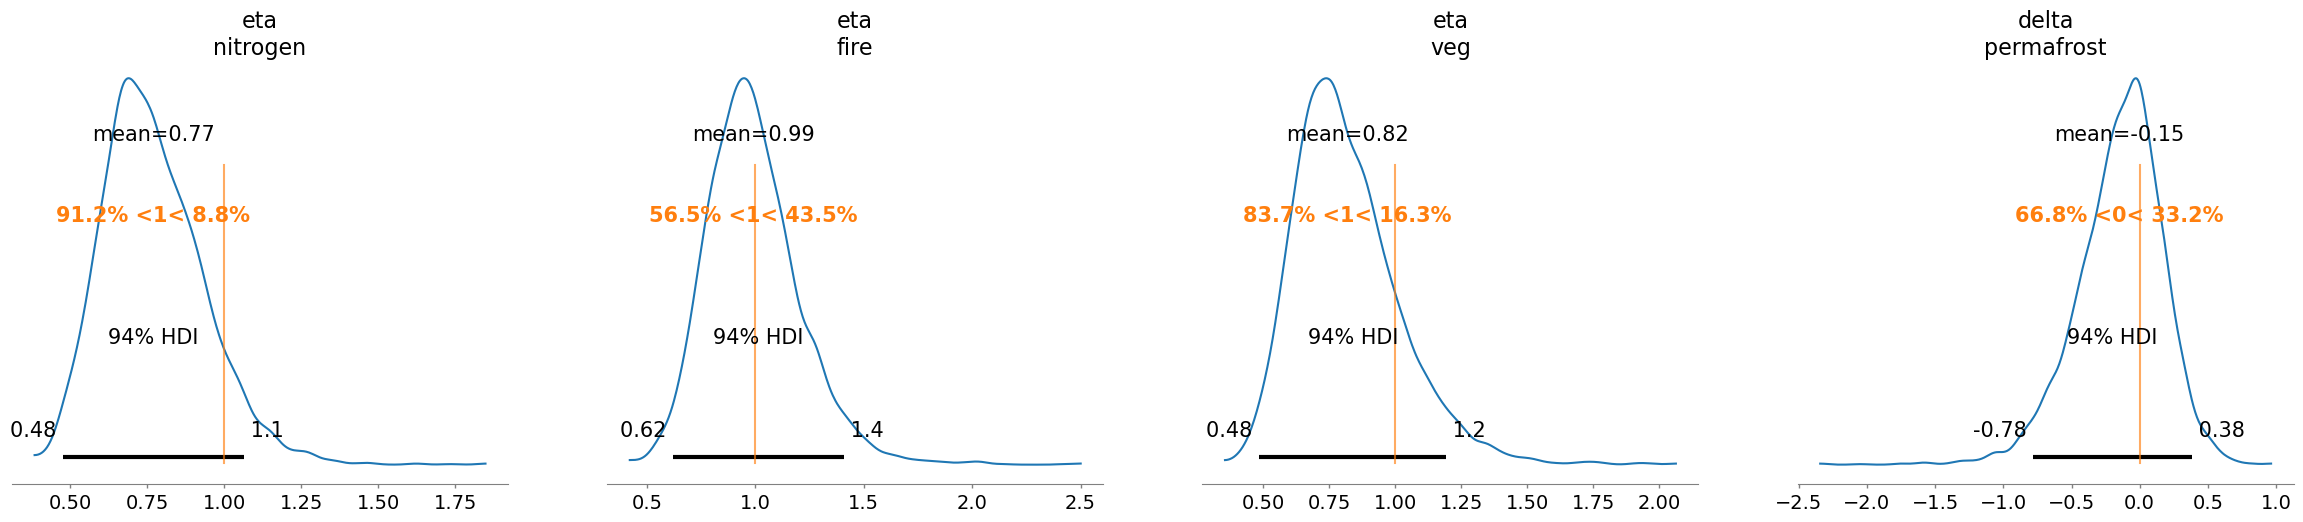

In [44]:
az.plot_posterior(alltrace,var_names=["eta","delta"],ref_val=[1,1,1,0])

This isn't surprising- the CMIP ESMSs don't really provide enough information to constrain fire, veg, permafrost.

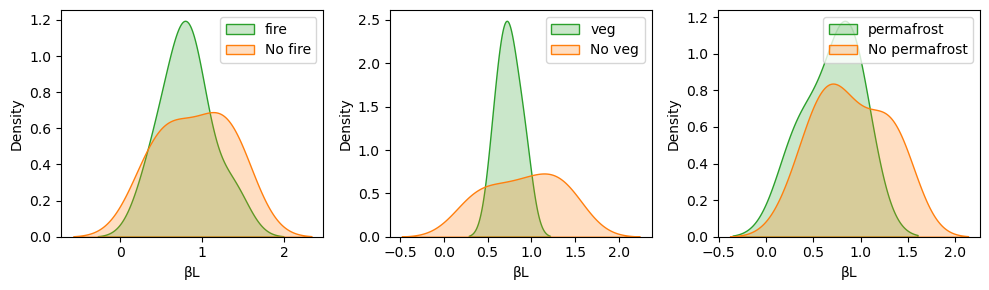

In [62]:
plt.figure(figsize=(10,3))
plt.subplot(131)
plot_comparison("fire")
plt.subplot(132)
plot_comparison("veg")
plt.subplot(133)
plot_comparison("permafrost")
plt.tight_layout()

# We need the priors to do a lot of work for us!
In the case of nitrogen limitations, the models are about 50/50 has process/doesn't.  That, plus the robust physical understanding embedded in the ESMs, means that we can be fairly confident that $\eta_{N}$ is less than 1.  
But for the other processes, we either 1) don't have enough models that included them 2) don't really understand the physical mechanisms by which they affect $\beta_L$.  So the posteriors are unconstrained.  

Note that the "All process" posterior allows for negative values of $\beta_L$ even though my prior on unscaled $\beta_L$ was positive definite.  This is because I used a wide prior on $\delta_{permafrost}$, which allows for the permafrost contribution to be quite negative.  And because permafrost is assumed to be additive, this can drag total $\beta_L$ down to negative values.  If we want to guard against this, we need to specify it in the prior- the CMIP models won't give us the information we need to constrain it.

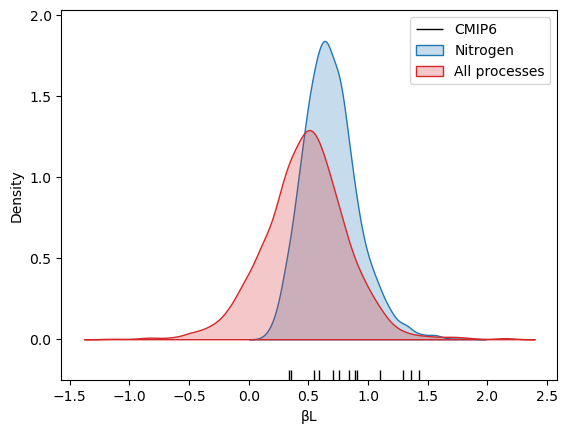

In [50]:
sns.rugplot(carbon_cycle_cmip["betaL"],c="k",label="CMIP6")
plot_helpers.plot_posterior(nitrogentrace,"betaL",label="Nitrogen",fill=True)
plot_helpers.plot_posterior(alltrace,"betaL",label="All processes",color=cm.tab10(3),fill=True)
plt.xlabel("βL")
plt.legend()


# Not all hope is lost!
Using the process-based runs, we can constrain $\eta$ and $\delta$.  To do by Friday: add modules that include this information.  Explicitly tie to WIIMIP.  ASK CHRIS: can we use ACCESS/UKESM data?